In [1]:
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import xarray as xr
from qcodes import Instrument, ManualParameter, Parameter, validators
from scipy.optimize import minimize_scalar

import quantify_core.data.handling as dh
from quantify_core.analysis import base_analysis as ba
from quantify_core.analysis import cosine_analysis as ca
from quantify_core.measurement import Gettable, MeasurementControl
from quantify_core.utilities.dataset_examples import mk_2d_dataset_v1
from quantify_core.utilities.examples_support import mk_cosine_instrument
from quantify_core.utilities.inspect_utils import display_source_code

dh.set_datadir(dh.default_datadir())
meas_ctrl = MeasurementControl("meas_ctrl")

Data will be saved in:
C:\Users\labuser\quantify-data


In [2]:
from quantify_core.visualization.pyqt_plotmon import PlotMonitor_pyqt
InteractiveShell.ast_node_interactivity = "all"

In [4]:
plotmon = PlotMonitor_pyqt("plotmon")
meas_ctrl.instr_plotmon(plotmon.name)

C:\Users\labuser\miniconda3\envs\temp2_env\Lib\site-packages\quantify_core\visualization\pyqt_plotmon_remote.py:18: QCoDeSDeprecationWarning: The qcodes.plots is deprecated. Use "qcodes_loop.plots" as an alternative.
  from qcodes.plots.colors import color_cycle
C:\Users\labuser\miniconda3\envs\temp2_env\Lib\site-packages\quantify_core\visualization\pyqt_plotmon_remote.py:18: QCoDeSDeprecationWarning: The qcodes.plots.colors is deprecated. Use "qcodes_loop.plots.colors" as an alternative.
  from qcodes.plots.colors import color_cycle
C:\Users\labuser\miniconda3\envs\temp2_env\Lib\site-packages\qcodes\plots\pyqtgraph.py:17: QCoDeSDeprecationWarning: The qcodes.utils.qt_helpers module is deprecated. Use "qcodes_loop.utils.qt_helpers" as an alternative.
  import qcodes.utils.qt_helpers
C:\Users\labuser\miniconda3\envs\temp2_env\Lib\site-packages\quantify_core\visualization\pyqt_plotmon_remote.py:19: QCoDeSDeprecationWarning: The qcodes.plots.pyqtgraph is deprecated. Use "qcodes_loop.plots

Starting iterative measurement...
100% completed | elapsed time:      0s | time left:      0s  
100% completed | elapsed time:      0s | time left:      0s  

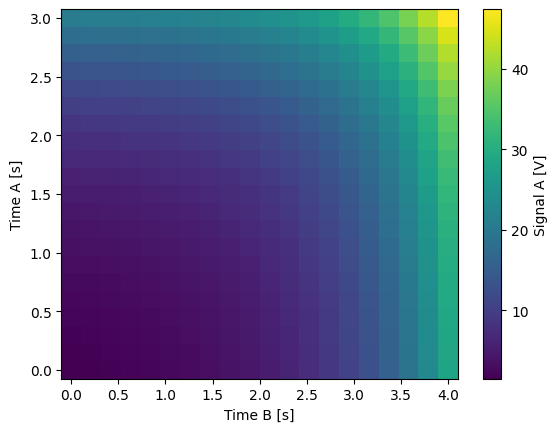

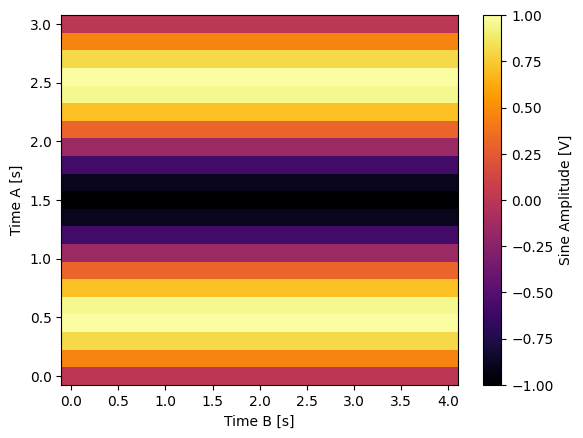

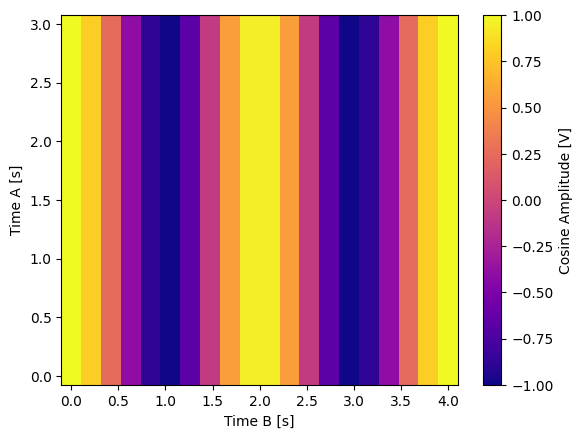

<xarray.Dataset>
Dimensions:  (x0: 21, x1: 20)
Coordinates:
  * x0       (x0) float64 0.0 0.15 0.3 0.45 0.6 0.75 ... 2.4 2.55 2.7 2.85 3.0
  * x1       (x1) float64 0.0 0.2105 0.4211 0.6316 ... 3.368 3.579 3.789 4.0
Data variables:
    y0       (x0, x1) float64 1.5 1.617 1.762 1.94 ... 34.6 38.0 42.2 47.38
    y1       (x0, x1) float64 0.0 0.0 0.0 0.0 ... 3.674e-16 3.674e-16 3.674e-16
    y2       (x0, x1) float64 1.0 0.7891 0.2455 -0.4017 ... 0.2455 0.7891 1.0
Attributes:
    tuid:                             20230911-143555-367-8fd8c6
    name:                             my experiment
    grid_2d:                          False
    grid_2d_uniformly_spaced:         True
    1d_2_settables_uniformly_spaced:  False
    xlen:                             21
    ylen:                             20

In [5]:
time_a = ManualParameter(
    name="time_a", label="Time A", unit="s", vals=validators.Numbers(), initial_value=1
)
time_b = ManualParameter(
    name="time_b", label="Time B", unit="s", vals=validators.Numbers(), initial_value=1
)

signal = Parameter(
    name="sig_a",
    label="Signal A",
    unit="V",
    get_cmd=lambda: np.exp(time_a()) + 0.5 * np.exp(time_b()),
)


class DualWave2D:
    """A "dual" gettable example that depends on two settables."""

    def __init__(self):
        self.unit = ["V", "V"]
        self.label = ["Sine Amplitude", "Cosine Amplitude"]
        self.name = ["sin", "cos"]

    def get(self):
        """Returns the value of the gettable."""
        return np.array([np.sin(time_a() * np.pi), np.cos(time_b() * np.pi)])


dual_wave = DualWave2D()
meas_ctrl.settables([time_a, time_b])
meas_ctrl.gettables([signal, dual_wave])
meas_ctrl.setpoints_grid([np.linspace(0, 3, 21), np.linspace(4, 0, 20)])
dset = meas_ctrl.run("my experiment")
dset_grid = dh.to_gridded_dataset(dset)

for yi, cmap in zip(("y0", "y1", "y2"), ("viridis", "inferno", "plasma")):
    dset_grid[yi].plot(cmap=cmap)
    plt.show()
dset_grid